# Test MemoryExperiemnt and NoiseModel

In [1]:
import sys
print(sys.path)

['/Users/liamveeder-sweeney/opt/anaconda3/envs/qec_software/lib/python311.zip', '/Users/liamveeder-sweeney/opt/anaconda3/envs/qec_software/lib/python3.11', '/Users/liamveeder-sweeney/opt/anaconda3/envs/qec_software/lib/python3.11/lib-dynload', '', '/Users/liamveeder-sweeney/opt/anaconda3/envs/qec_software/lib/python3.11/site-packages', '/Users/liamveeder-sweeney/Careers research/2. Quantum/0. Edinburgh/QEC/qec_software/Github/qec/src']


In [2]:
# Imports

import numpy as np
import stim
import matplotlib.pyplot as plt
import os
sys.path.append(os.path.abspath('..'))

from qec.code_constructions import HypergraphProductCode
from qec.circuit_compilation.noise_model import NoiseModel
#from qec.utils.honeycomb_noise_gidney import NoiseModel as GidneyNoiseModel
from qec.circuit_compilation.memory_experiment.memory_experiment import MemoryExperiment

## Simple noisy circuit (examples)

H 0
CX 0 1
MX 0
TICK
H 2


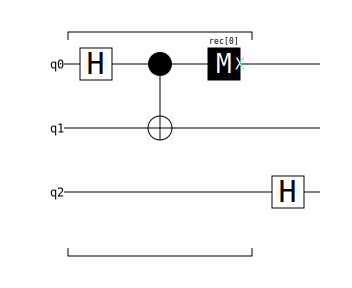

In [3]:
# Example 1
model = NoiseModel(
    idle_depolarization=0.01,
    measure={"X": 0.05, "Y": 0.05, "Z": 0.05},
    reset={"X": 0.02, "Y": 0.02, "Z": 0.02},
    gates={"H": 0.01, "CNOT": 0.02},
    any_clifford_1=0.01,
    any_clifford_2=0.02,
)
c = stim.Circuit("H 0\nCNOT 0 1\nMX 0\nTICK\nH 2")
print(c)
c.diagram('timeline-svg')


H 0
DEPOLARIZE1(0.01) 0
CX 0 1
DEPOLARIZE2(0.02) 0 1
Z_ERROR(0.05) 0
MX 0
DEPOLARIZE1(0.01) 2
TICK
H 2
DEPOLARIZE1(0.01) 2


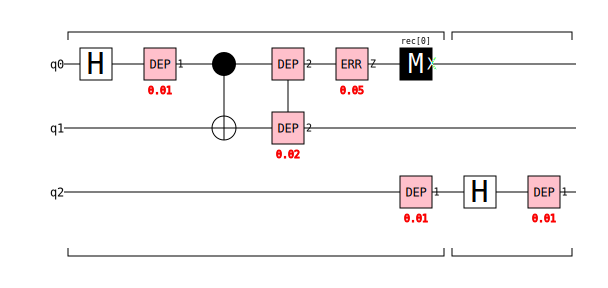

In [4]:
noisy = model.noisy_circuit(c)
print(noisy)
noisy.diagram('timeline-svg')

In [5]:
# Example 2 - Repetition code (Coursera)
rep_code = stim.Circuit("""
    R 0 1 2 3 4                       
    TICK
    CX 0 1 2 3
    TICK
    CX 2 1 4 3  
    TICK                    
    M 1 3
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]
    R 1 3
    TICK
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    M 1 3
    SHIFT_COORDS(0, 1)
    DETECTOR(1, 0) rec[-2] rec[-4]
    DETECTOR(3, 0) rec[-1] rec[-3]
    R 1 3
    TICK
    CX 0 1 2 3
    TICK
    CX 2 1 4 3
    TICK
    M 1 3 0 2 4
    SHIFT_COORDS(0, 1)
    DETECTOR(1, 0) rec[-5] rec[-7]
    DETECTOR(3, 0) rec[-4] rec[-6]
    DETECTOR(1, 0) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 0) rec[-1] rec[-2] rec[-4]
    OBSERVABLE_INCLUDE(0) rec[-1]
""")
#rep_code.diagram('timeline-svg')

In [6]:
# Noisy version of the repetition code
noisy_rep_code = stim.Circuit("""
    R 0 1 2 3 4                       
    X_ERROR(0.001) 0 1 2 3 4
    TICK
    CX 0 1 2 3
    DEPOLARIZE2(0.001) 0 1 2 3
    DEPOLARIZE1(0.001) 4
    TICK
    CX 2 1 4 3
    DEPOLARIZE2(0.001) 2 1 4 3
    DEPOLARIZE1(0.001) 0   
    TICK                    
    X_ERROR(0.001) 1 3
    M 1 3
    DEPOLARIZE1(0.001) 0 2 4
    DETECTOR(1, 0) rec[-2]
    DETECTOR(3, 0) rec[-1]
    R 1 3
    X_ERROR(0.001) 1 3
    DEPOLARIZE1(0.001) 0 2 4
    TICK
    CX 0 1 2 3
    DEPOLARIZE2(0.001) 0 1 2 3
    DEPOLARIZE1(0.001) 4
    TICK
    CX 2 1 4 3
    DEPOLARIZE2(0.001) 2 1 4 3
    DEPOLARIZE1(0.001) 0
    TICK
    X_ERROR(0.001) 1 3
    M 1 3
    DEPOLARIZE1(0.001) 0 2 4
    SHIFT_COORDS(0, 1)
    DETECTOR(1, 0) rec[-2] rec[-4]
    DETECTOR(3, 0) rec[-1] rec[-3]
    R 1 3
    X_ERROR(0.001) 1 3
    DEPOLARIZE1(0.001) 0 2 4
    TICK
    CX 0 1 2 3
    DEPOLARIZE2(0.001) 0 1 2 3
    DEPOLARIZE1(0.001) 4
    TICK
    CX 2 1 4 3
    DEPOLARIZE2(0.001) 2 1 4 3
    DEPOLARIZE1(0.001) 0
    TICK
    X_ERROR(0.001) 1 3 0 2 4 
    M 1 3 0 2 4
    SHIFT_COORDS(0, 1)
    DETECTOR(1, 0) rec[-5] rec[-7]
    DETECTOR(3, 0) rec[-4] rec[-6]
    DETECTOR(1, 0) rec[-2] rec[-3] rec[-5]
    DETECTOR(3, 0) rec[-1] rec[-2] rec[-4]
    OBSERVABLE_INCLUDE(0) rec[-1]
""")
#noisy_rep_code.diagram('timeline-svg')

In [7]:
# Our version of the noisy repetion code
my_noise_model = NoiseModel(
    idle_depolarization=0.001,  # Idle depolarizing noise on untouched qubits before each TICK
    measure={"X": 0.0, "Y": 0.0, "Z": 0.001},  # Bit-flip before Z-basis measurement
    reset={"X": 0.0, "Y": 0.0, "Z": 0.001},    # Bit-flip after Z-basis reset
    gates={"H": 0.001, "CNOT": 0.001},         # Depolarizing 2-qubit noise after CNOT
    any_clifford_1=0.001,
    any_clifford_2=0.001
)

our_noisy_rep_code = my_noise_model.noisy_circuit(rep_code)

In [8]:
# Our version of a depolarizing noisy repetition code
dep_noise_model = NoiseModel.uniform_depolarizing_noise(0.001)

dep_noisy_rep_code = dep_noise_model.noisy_circuit(rep_code)

In [9]:
# # Gidney version of the noisy repetition code
# gidney_noise_model = GidneyNoiseModel(
#     idle=0.001,  # Idle depolarizing noise on untouched qubits before each TICK
#     measure_reset_idle=0.001,  # Z-reset followed by X-error and Z-measurement with X-error
#     noisy_gates={"H": 0.001, "CNOT": 0.001, "R": 0.001, "M": 0.001},
#     any_clifford_1=0.001,
#     any_clifford_2=0.001,
#     use_correlated_parity_measurement_errors=False,
# )

# gidney_noisy_rep_code = gidney_noise_model.noisy_circuit(rep_code)

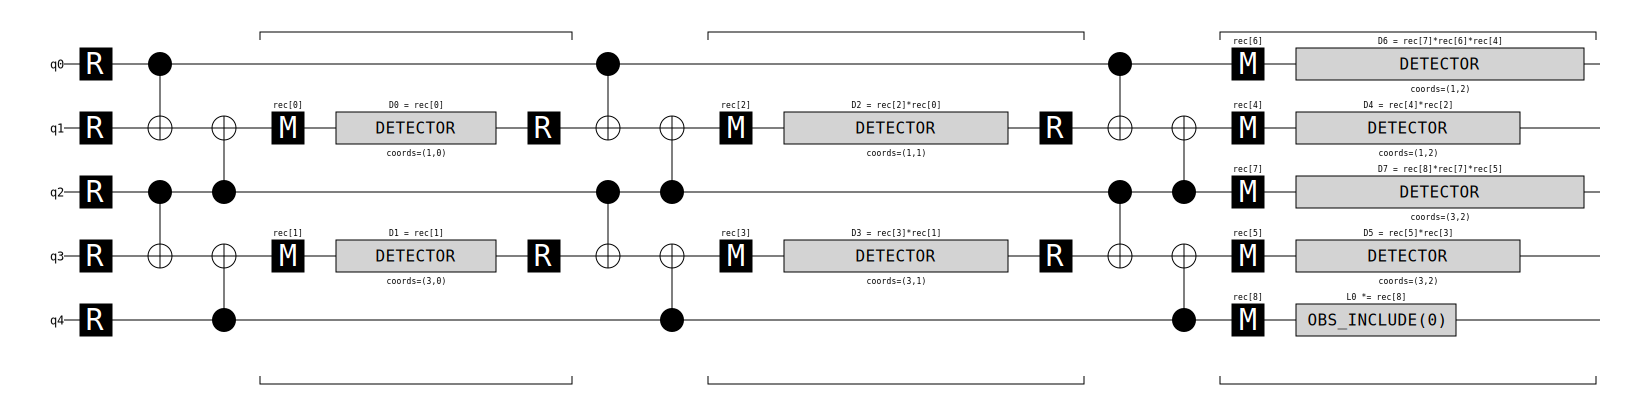

In [10]:
rep_code.diagram('timeline-svg')

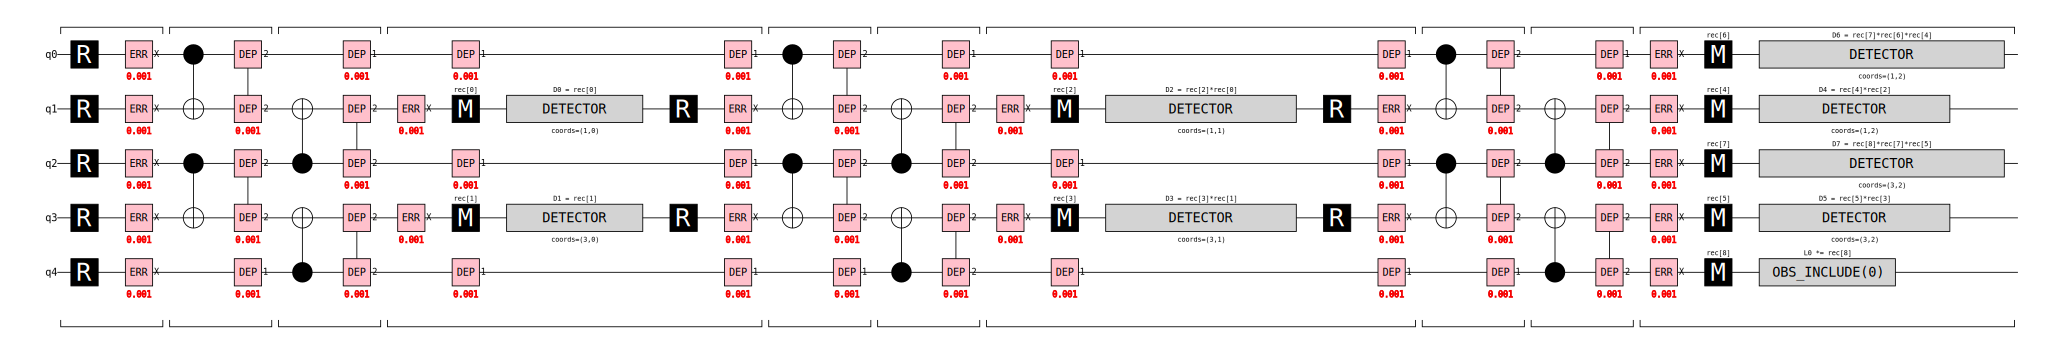

In [11]:
noisy_rep_code.diagram('timeline-svg')

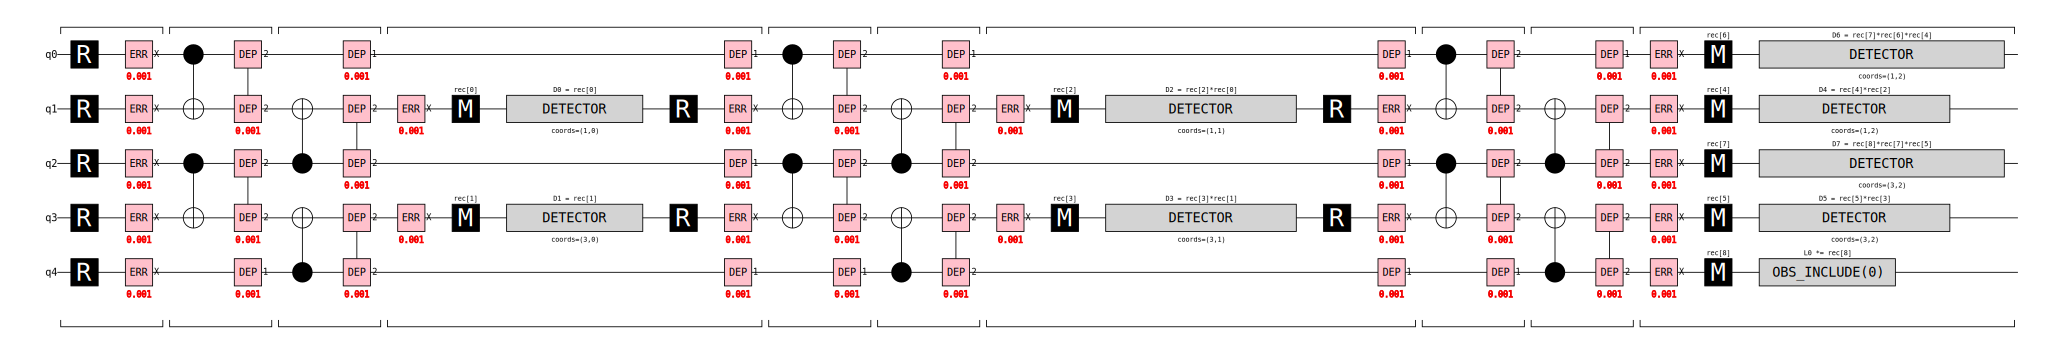

In [12]:
our_noisy_rep_code.diagram('timeline-svg')
# NOTE: The diagram is not exactly the same as above because the idle noise is applied
# per TICK round and misses a depolarising step in the mid-circuit measurement.

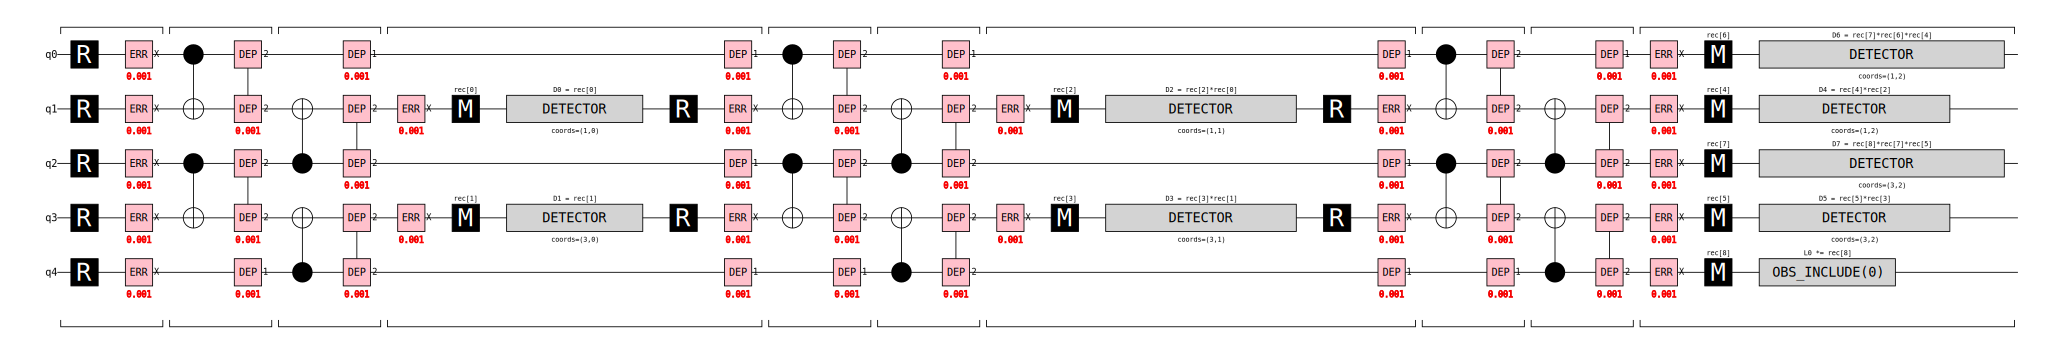

In [13]:
dep_noisy_rep_code.diagram('timeline-svg')

In [ ]:
#gidney_noisy_rep_code.diagram('timeline-svg')

## Code Construction - MemoryExperiment

In [16]:
from qec.code_constructions import CSSCode

hamming_code = np.array([[1, 0, 0, 1, 0, 1, 1],
                         [0, 1, 0, 1, 1, 0, 1],
                         [0, 0, 1, 0, 1, 1, 1]])

steane_code = CSSCode(x_stabilizer_matrix = hamming_code,
                      z_stabilizer_matrix = hamming_code,
                      name = 'Steane')
print(steane_code)

Steane Code: [[N=7, K=1, dx<=None, dz<=None]]


In [23]:
# TODO: Noisy version of the Steane code

### Code construction --> MemoryExperiment(Noise=True/False)
Added toggle to MemoryExperiment._coloration_circuit(noise = True/False)

In [24]:
# Create noise model
model = NoiseModel(
    idle_depolarization=0.01,
    measure={"X": 0.05, "Y": 0.05, "Z": 0.05},
    reset={"X": 0.02, "Y": 0.02, "Z": 0.02},
    gates={"H": 0.01, "CNOT": 0.02},
    any_clifford_1=0.01,
    any_clifford_2=0.02,
)

# # Create a noise model using Gidneys method
# gidney_model = GidneyNoiseModel(
#     idle=0.01,  # Idle depolarizing noise on untouched qubits before each TICK
#     measure_reset_idle=0.01,  # Z-reset followed by X-error and Z-measurement with X-error
#     noisy_gates={"H": 0.01, "CNOT": 0.02, "R": 0.02, "M": 0.05, "MX": 0.05, "RX": 0.02},
#     any_clifford_1=0.01,
#     any_clifford_2=0.02,
#     use_correlated_parity_measurement_errors=False,
# )

# Construct a hypergraph product code
three_repetition_code = np.array([[1, 1, 0],
                                  [0, 1, 1]])
example_code = HypergraphProductCode(three_repetition_code, three_repetition_code, name = 'example')


Noiseless circuit:


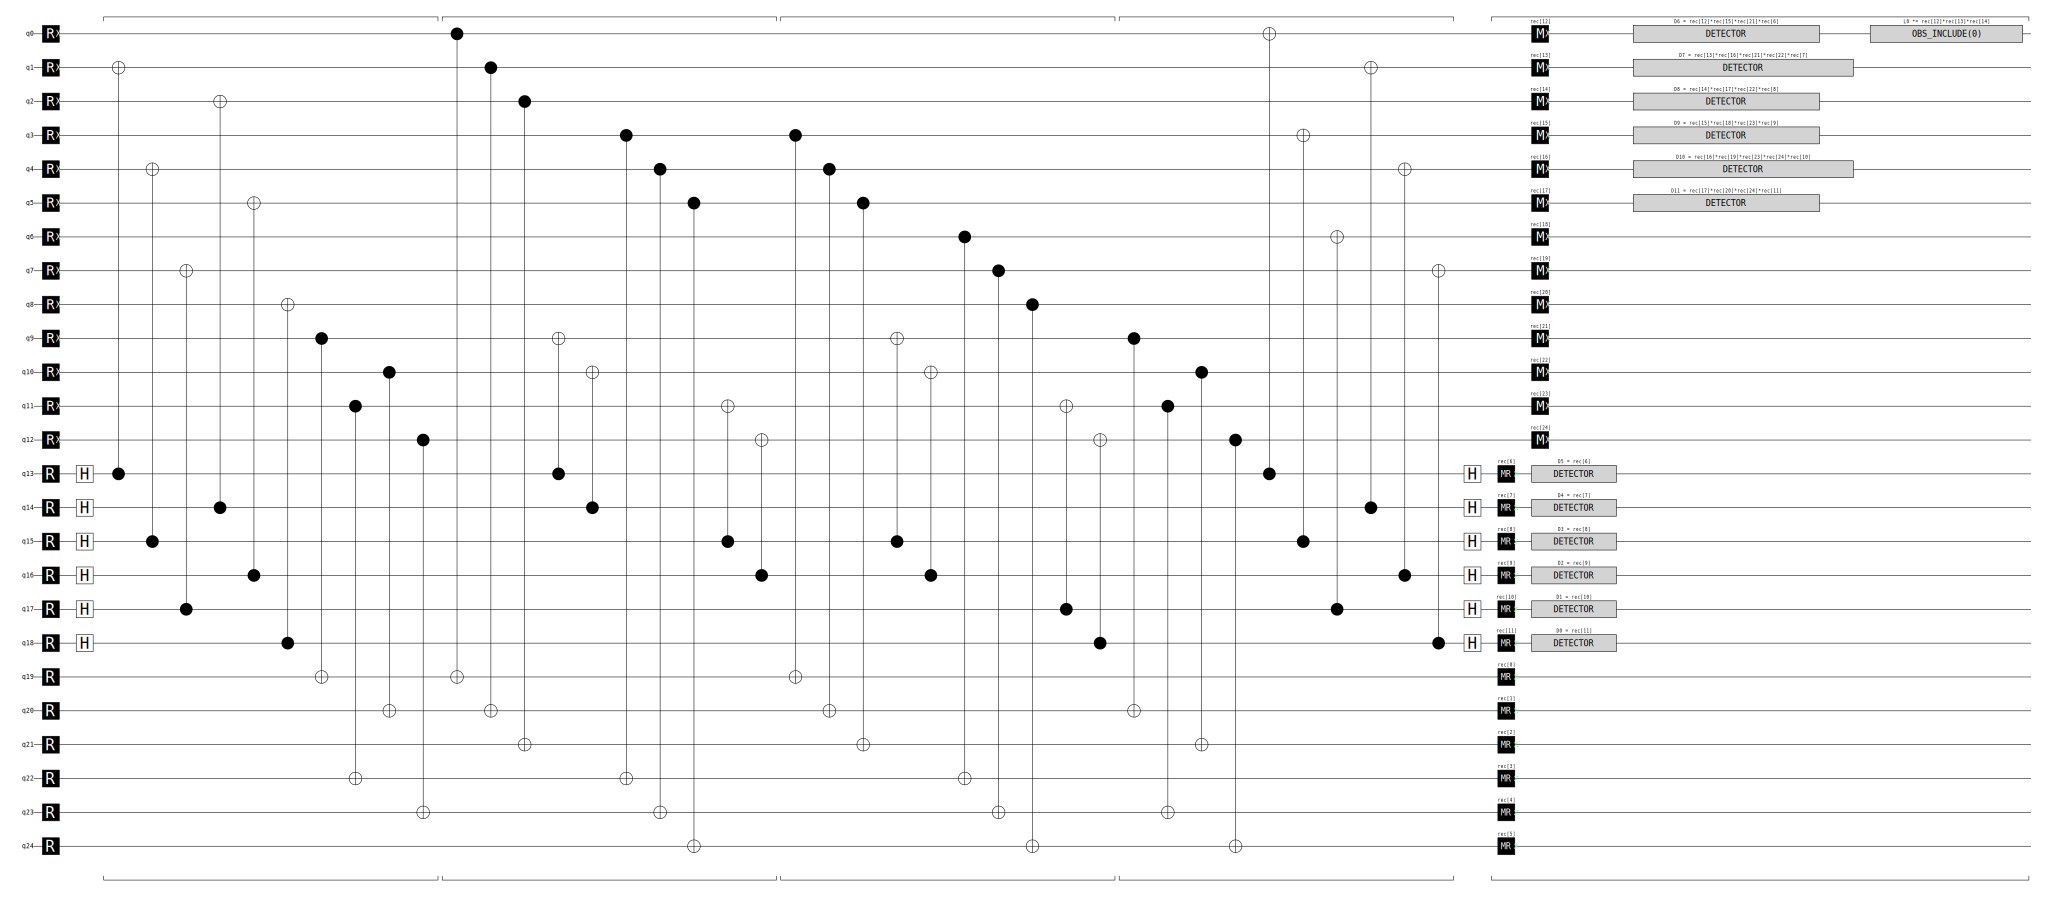

In [25]:
# Create a stim circuit by calling the circuit() method in the MemoryExperiment class
# Use the toggle to choose whether or not to add noise
hgp_memory = MemoryExperiment(example_code, noise_model=model)
circuit2 = hgp_memory.circuit(basis = 'X', rounds = 1, noise = False)
noisy_circuit2 = hgp_memory.circuit(basis = 'X', rounds = 1, noise = True)

# Noise = False
print("\nNoiseless circuit:")
#print(circuit2)
circuit2.diagram('timeline-svg')


Noisy Circuit:


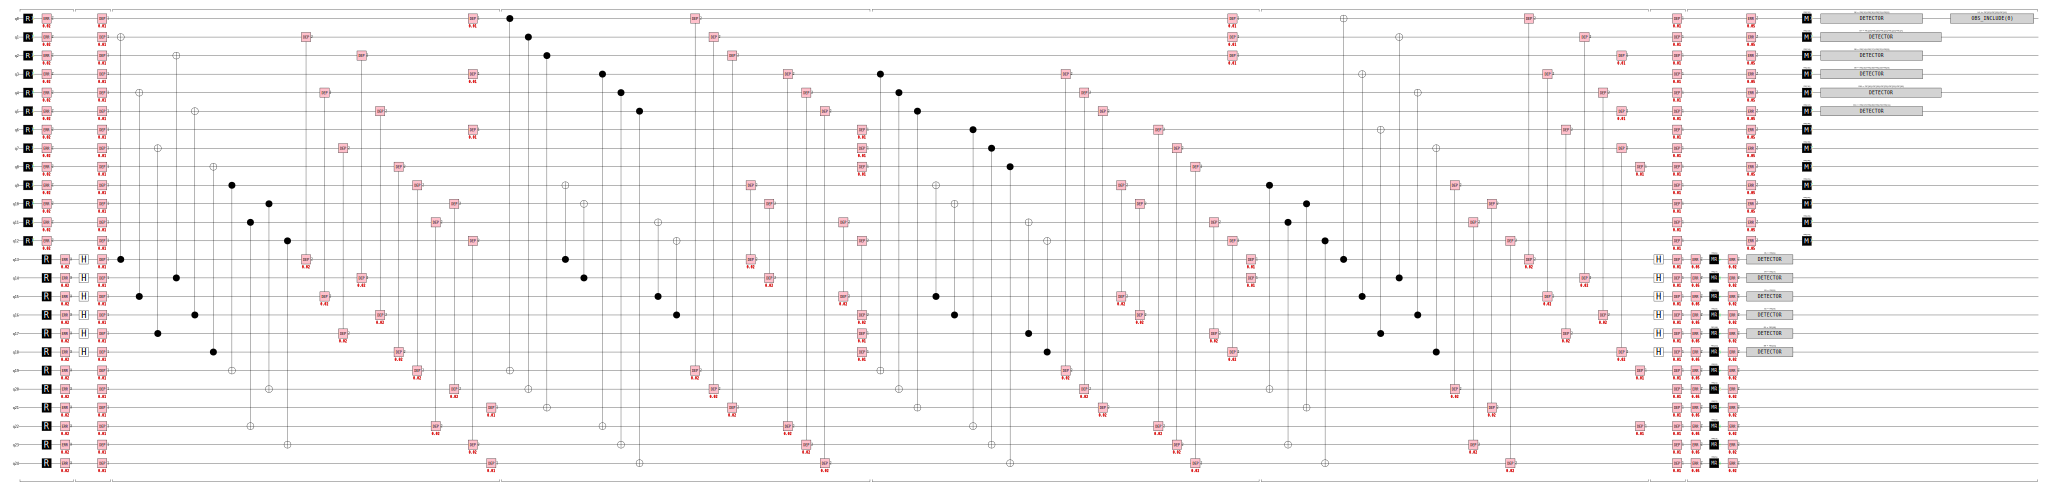

In [26]:
# Noise = True
print("\nNoisy Circuit:")
#print(noisy_circuit2)
noisy_circuit2.diagram('timeline-svg')

In [27]:
# # GIGNEY VERSION

# # Create a stim circuit by calling the _coloration_circuit method in the MemoryExperiment class
# # Use the toggle to choose whether or not to add noise
# hgp_memory = MemoryExperiment(example_code, noise_model=gidney_model)
# gidney_circuit2 = hgp_memory._coloration_circuit(basis = 'X', rounds = 1, noise = False)

# fixed_circuit2 = stim.Circuit()
# for inst in gidney_circuit2:
#     if inst.name == "MRX":
#         for q in inst.targets_copy():
#             fixed_circuit2.append_operation("RX", [q])
#             fixed_circuit2.append_operation("MX", [q])
#     else:
#         fixed_circuit2.append(inst)

# gidney_noisy_circuit2 = gidney_model.noisy_circuit(fixed_circuit2)

# print("\nNoisy Circuit:")
# #print(gidney_noisy_circuit2)
# gidney_noisy_circuit2.diagram('timeline-svg')

# Getting noise models from backend
- Qiskit - superconducting
- AWS (Braket) - Neutral Atom (QuEra)?
- Google (Cirq) - Superconducting
- Pennylane - Trapped Ions?

# Example IBM (Qiskit)

A run through of how one would use the Qiskit Aer simulator - A high-performance quantum circuit simualtor used in place of Qiskit primitives for exact and noisy simulation. 

https://docs.quantum.ibm.com/guides/build-noise-models

We will then see how we can build on this functionality with our package:
- Call from the qiskit-aer backend to get (real) hardware specific noise models
- Call to implement general noisy circuit simulations (already developed?)
- Translate between Open QASM, Stim and other circuit types

In [28]:
# IBM Example
import qiskit
import numpy as np

In [29]:
# Disable debug logs by adjusting the Python logging level
import logging

# Set the logging level to WARNING to hide DEBUG and INFO logs
logging.getLogger().setLevel(logging.WARNING)

In [30]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Kraus, SuperOp
from qiskit.visualization import plot_histogram
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
 
# Import from Qiskit Aer noise module
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

## Qiskit Aer noise module
The Qiskit Aer noise module contains Python classes to build customized noise models for simulation. There are three key classes:

1. The NoiseModel class which stores a noise model used for noisy simulation.

2. The QuantumError class which describes CPTP gate errors. These can be applied:
- After gate or reset instructions
- Before measure instructions.

3. The ReadoutError class which describes classical readout errors.

## Initialising a noise model from a backend

In [31]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
noise_model = NoiseModel.from_backend(backend)
print(noise_model)

NoiseModel:
  Basis gates: ['delay', 'ecr', 'for_loop', 'id', 'if_else', 'measure', 'reset', 'rz', 'switch_case', 'sx', 'x']
  Instructions with noise: ['reset', 'id', 'sx', 'x', 'ecr', 'measure']
  Qubits with noise: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('reset', (4,)), ('reset', (5,)), ('reset', (6,)), ('reset', (7,)), ('reset', (8,)), ('reset', (9,)), ('reset', (10,)), ('reset', (11,)), ('reset', (12,)), ('rese

## Adding errors to a noise model

When adding a quantum error to a noise model, we must specify the type of instruction that it acts on and what qubits to apply it to. There are two cases of quantum errors:

1. All-qubit quantum error
2. Specific qubit quantum error

### 1. All qubit quantum error
`noise_model.add_all_qubit_quantum_error(error, instructions)`

In [32]:
# Create an empty noise model
noise_model = NoiseModel()
 
# Add depolarizing error to all single qubit u1, u2, u3 gates
error = depolarizing_error(0.05, 1)
noise_model.add_all_qubit_quantum_error(error, ["u1", "u2", "u3"])
 
# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1']
  All-qubits errors: ['u1', 'u2', 'u3']


### 2. Specific quantum error
`noise_model.add_quantum_error(error, instructions, qubits)`

In [33]:
# Create an empty noise model
noise_model = NoiseModel()
 
# Add depolarizing error to all single qubit u1, u2, u3 gates on qubit 0 only
error = depolarizing_error(0.05, 1)
noise_model.add_quantum_error(error, ["u1", "u2", "u3"], [0])
 
# Print noise model info
print(noise_model)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['u3', 'u2', 'u1']
  Qubits with noise: [0]
  Specific qubit errors: [('u1', (0,)), ('u2', (0,)), ('u3', (0,))]


## Noise model examples

### 1. Set up an example circuit
--> e.g. use a simple test circuit generating a n-qubit GHZ state

In [34]:
# System Specification 
n_qubits = 4
circ = QuantumCircuit(n_qubits)
 
# Test Circuit
circ.h(0)
for qubit in range(n_qubits - 1):
    circ.cx(qubit, qubit + 1)
circ.measure_all()
print(circ)

        ┌───┐                ░ ┌─┐         
   q_0: ┤ H ├──■─────────────░─┤M├─────────
        └───┘┌─┴─┐           ░ └╥┘┌─┐      
   q_1: ─────┤ X ├──■────────░──╫─┤M├──────
             └───┘┌─┴─┐      ░  ║ └╥┘┌─┐   
   q_2: ──────────┤ X ├──■───░──╫──╫─┤M├───
                  └───┘┌─┴─┐ ░  ║  ║ └╥┘┌─┐
   q_3: ───────────────┤ X ├─░──╫──╫──╫─┤M├
                       └───┘ ░  ║  ║  ║ └╥┘
meas: 4/════════════════════════╩══╩══╩══╩═
                                0  1  2  3 


## 2. Run an ideal simulation

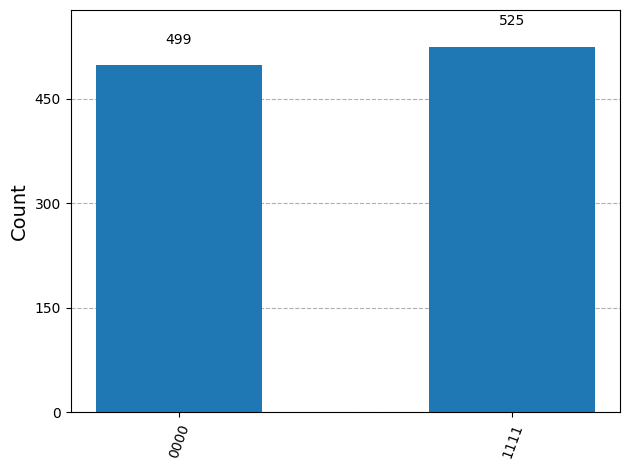

In [36]:
# Ideal simulator and execution
sim_ideal = AerSimulator()
result_ideal = sim_ideal.run(circ).result() # Default number of shots is 1024
plot_histogram(result_ideal.get_counts(0))

### Noise example 1: Basic bit-flip error noise model

In [37]:
# Example error probabilities
p_reset = 0.03
p_meas = 0.1
p_gate1 = 0.05
 
# QuantumError objects
error_reset = pauli_error([("X", p_reset), ("I", 1 - p_reset)])
error_meas = pauli_error([("X", p_meas), ("I", 1 - p_meas)])
error_gate1 = pauli_error([("X", p_gate1), ("I", 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)
 
# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])
 
print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u1', 'u2', 'u3']
  Instructions with noise: ['reset', 'u1', 'cx', 'u3', 'u2', 'measure']
  All-qubits errors: ['reset', 'measure', 'u1', 'u2', 'u3', 'cx']


### Execute the noisy simulation

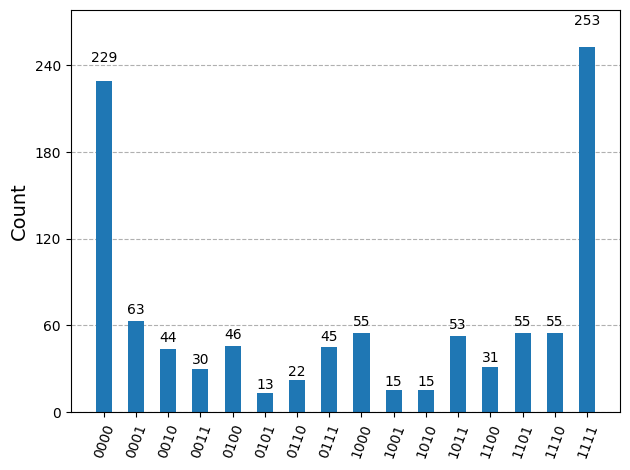

In [38]:
# Create noisy simulator backend
sim_noise = AerSimulator(noise_model=noise_bit_flip)
 
# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(
    optimization_level=3, backend=sim_noise
)
circ_tnoise = passmanager.run(circ)
 
# Run and get counts
result_bit_flip = sim_noise.run(circ_tnoise).result()
counts_bit_flip = result_bit_flip.get_counts(0)
 
# Plot noisy output
plot_histogram(counts_bit_flip)

## Example 2: T1/T2 thermal relaxation

Now consider a more realistic error model based on thermal relaxation with the qubit environment:
- Each qubit is parameterized by a thermal relaxation time constant $T_1$ and a dephasing time constant $T_2$
- Note that we must have $T_2 \ge 2T_1$
- Error rates on instructions are determined by gate times and qubit $T_1$, $T_2$ values

In [39]:
# T1 and T2 values for qubits 0-3
T1s = np.random.normal(
    50e3, 10e3, 4
)  # Sampled from normal distribution mean 50 microsec
T2s = np.random.normal(
    70e3, 10e3, 4
)  # Sampled from normal distribution mean 50 microsec
 
# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(4)])
 
# Instruction times (in nanoseconds)
time_u1 = 0  # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100  # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000  # 1 microsecond
 
# QuantumError objects
errors_reset = [
    thermal_relaxation_error(t1, t2, time_reset) for t1, t2 in zip(T1s, T2s)
]
errors_measure = [
    thermal_relaxation_error(t1, t2, time_measure) for t1, t2 in zip(T1s, T2s)
]
errors_u1 = [
    thermal_relaxation_error(t1, t2, time_u1) for t1, t2 in zip(T1s, T2s)
]
errors_u2 = [
    thermal_relaxation_error(t1, t2, time_u2) for t1, t2 in zip(T1s, T2s)
]
errors_u3 = [
    thermal_relaxation_error(t1, t2, time_u3) for t1, t2 in zip(T1s, T2s)
]
errors_cx = [
    [
        thermal_relaxation_error(t1a, t2a, time_cx).expand(
            thermal_relaxation_error(t1b, t2b, time_cx)
        )
        for t1a, t2a in zip(T1s, T2s)
    ]
    for t1b, t2b in zip(T1s, T2s)
]
 
# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(4):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(4):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])
 
print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'u2', 'u3']
  Instructions with noise: ['reset', 'cx', 'u3', 'u2', 'measure']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('u2', (0,)), ('u2', (1,)), ('u2', (2,)), ('u2', (3,)), ('u3', (0,)), ('u3', (1,)), ('u3', (2,)), ('u3', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


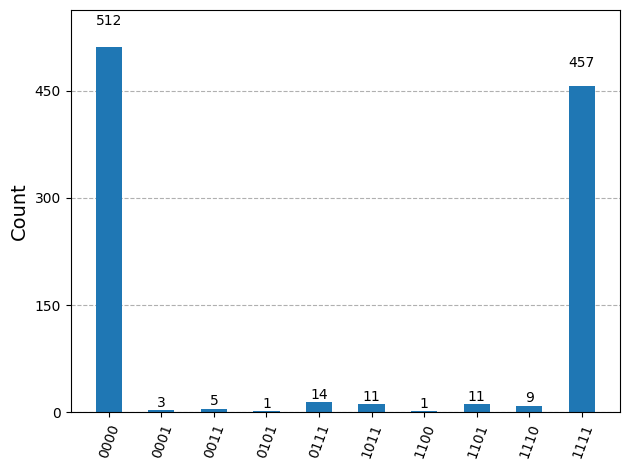

In [40]:
# Run the noisy simulation
sim_thermal = AerSimulator(noise_model=noise_thermal)
 
# Transpile circuit for noisy basis gates
passmanager = generate_preset_pass_manager(
    optimization_level=3, backend=sim_thermal
)
circ_tthermal = passmanager.run(circ)
 
# Run and get counts
result_thermal = sim_thermal.run(circ_tthermal).result()
counts_thermal = result_thermal.get_counts(0)
 
# Plot noisy output
plot_histogram(counts_thermal)

# Efficient simulation of stabilizer circuits with Qiskit Aer primitives

Stabiliser circuits, also known as Cliford circuits, can be defined as circuits solely composed of the following gates:
- CX
- Hadamard
- S
- Measurement

*Note* that Hadamard and S can be used to create any Pauli rotation gate ($R_x$, $R_y$, $R_z$) that has an angle contained in the set $\{0, \pi/2 , \pi, 3\pi/2\}$ (up to global phase), hence these are also included by default.


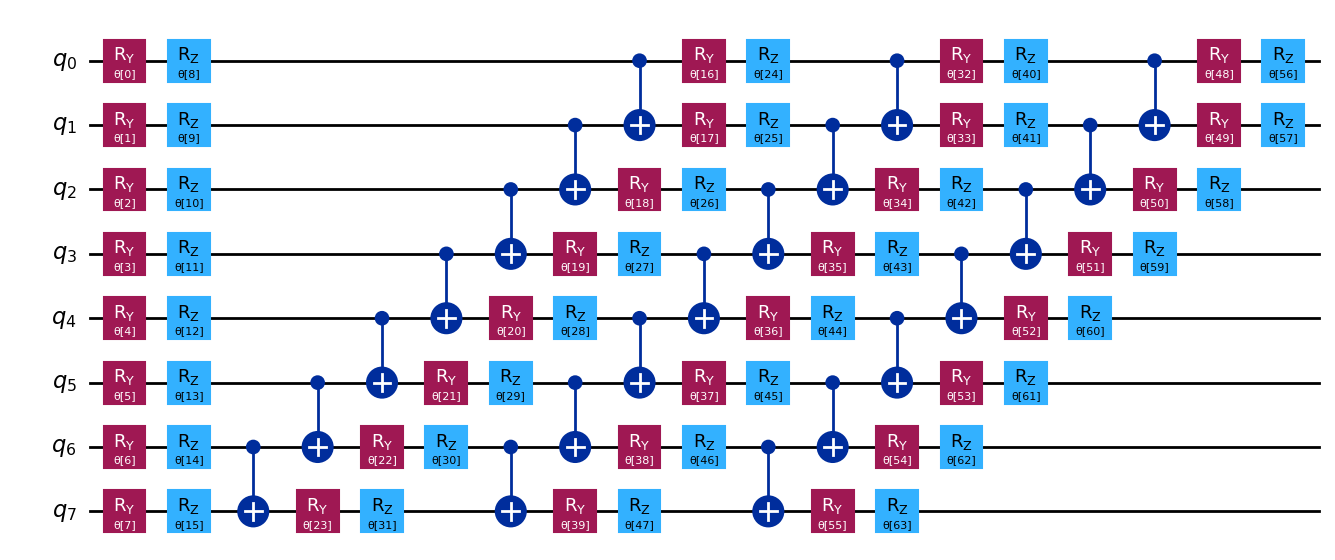

In [41]:
from qiskit.circuit.library import efficient_su2
 
n_qubits = 8
circuit = efficient_su2(n_qubits)
circuit.draw("mpl")

Qiskit Aer can simulate the above too easily, but see what happens when we try $n = 500$ qubits.

In [42]:
n_qubits = 500
circuit = efficient_su2(n_qubits)
# don't try to draw the circuit because it's too large

In most cases this couldn't be simulated, but if the circuit is a stabiliser circuit it still can.

In [43]:
import numpy as np
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler
 
measured_circuit = circuit.copy()
measured_circuit.measure_all()
 
rng = np.random.default_rng(1234)
params = rng.choice(
    [0, np.pi / 2, np.pi, 3 * np.pi / 2],
    size=circuit.num_parameters,
)
 
# Initialize a Sampler backed by the stabilizer circuit simulator
exact_sampler = Sampler(
    options=dict(backend_options=dict(method="stabilizer"))
)
# The circuit needs to be transpiled to the AerSimulator target
pass_manager = generate_preset_pass_manager(
    1, AerSimulator(method="stabilizer")
)
isa_circuit = pass_manager.run(measured_circuit)
pub = (isa_circuit, params)
job = exact_sampler.run([pub])
result = job.result()
pub_result = result[0]
counts = pub_result.data.meas.get_counts()

The stabilizer circuit simulator also supports noisy simulation, but only for a restricted class of noise models. Specifically, any quantum noise must be characterized by a Pauli error channel. Depolarizing error falls into this category, so it can be simulated too. Classical noise channels like readout error can also be simulated.

The following code cell runs the same simulation as before, but this time specifying a noise model that adds depolarizing error of 2% to each CX gate, as well as readout error that flips each measured bit with 5% probability.

In [44]:
from qiskit_aer.noise import NoiseModel, depolarizing_error, ReadoutError
 
noise_model = NoiseModel()
cx_depolarizing_prob = 0.02
bit_flip_prob = 0.05
noise_model.add_all_qubit_quantum_error(
    depolarizing_error(cx_depolarizing_prob, 2), ["cx"]
)
noise_model.add_all_qubit_readout_error(
    ReadoutError(
        [
            [1 - bit_flip_prob, bit_flip_prob],
            [bit_flip_prob, 1 - bit_flip_prob],
        ]
    )
)
 
noisy_sampler = Sampler(
    options=dict(
        backend_options=dict(method="stabilizer", noise_model=noise_model)
    )
)
job = noisy_sampler.run([pub])
result = job.result()
pub_result = result[0]
counts = pub_result.data.meas.get_counts()

Now, let's use the Estimator primitive backed by the stabilizer simulator to compute the expectation value of the observable $ZZ \ldots Z$. Due to the special structure of stabilizer circuits, the result is very likely to be 0.

In [45]:
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2 as Estimator
 
observable = SparsePauliOp("Z" * n_qubits)
 
exact_estimator = Estimator(
    options=dict(backend_options=dict(method="stabilizer")),
)
isa_circuit = pass_manager.run(circuit)
pub = (isa_circuit, observable, params)
job = exact_estimator.run([pub])
result = job.result()
pub_result = result[0]
exact_value = float(pub_result.data.evs)
exact_value

0.0